# Part 1 : Read Fiji NWP Data
To read data from WRF is quite different than GFS, you can use xarray directly to read the data but it will give you direct output of the model with coordinates originally from WRF (sigma level). To make it easier we will use wrf-python module. if you havent installed it you can do:<br>
<code>pip install wrf-python

## Read one file at a time

In [126]:
import wrf
from netCDF4 import Dataset
from wrf import getvar, interplevel, to_np, latlon_coords, get_cartopy, cartopy_xlim, cartopy_ylim
import os
import numpy as np
from matplotlib.ticker import FixedLocator

In [90]:
file_path = 'D:/Projects/fiji-training-2024/data/wrf/'
filename = "wrfout_d02_2024-06-24_00_00_00"

get the diagnostic variable using getvar, for full list of the variable you can refer to this resource:<br>
<a href='https://wrf-python.readthedocs.io/en/latest/diagnostics.html#diagnostic-table'> Table of Available Diagnostics </a>

In [94]:
ncfile = Dataset(os.path.join(file_path,filename))
slp = getvar(ncfile,'slp')

In [36]:
slp['Time']

<xarray.DataArray 'Time' ()>
array('2024-06-24T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    XTIME    float32 0.0
    Time     datetime64[ns] 2024-06-24

In [39]:
# to see the model resolution
slp['XLAT'][1][0]-slp['XLAT'][0][0]

<xarray.DataArray 'XLAT' ()>
array(0.02552795, dtype=float32)
Coordinates:
    XLONG    float32 173.9
    XTIME    float32 0.0
    Time     datetime64[ns] 2024-06-24

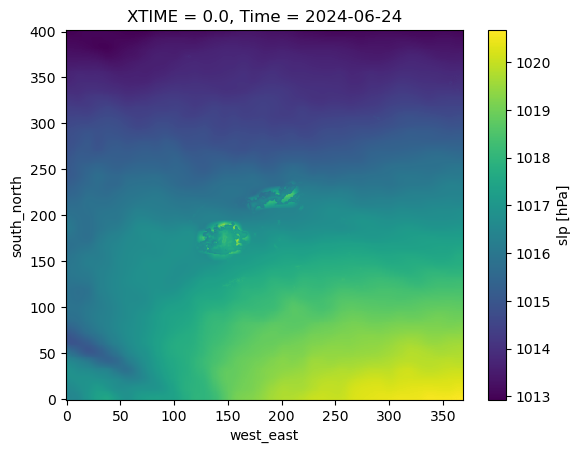

In [37]:
slp.plot()

## Open all files
Open all files in the directory and append it to one data in a time index

In [100]:
file_path = 'D:/Projects/fiji-training-2024/data/wrf/'

In [101]:
ncfiles = [Dataset(f"{file_path}{filename}") for filename in os.listdir(file_path)]
ncfiles

[<class 'netCDF4._netCDF4.Dataset'>
 root group (NETCDF4 data model, file format HDF5):
     TITLE:  OUTPUT FROM WRF V4.4.1 MODEL
     START_DATE: 2024-06-24_00:00:00
     SIMULATION_START_DATE: 2024-06-24_00:00:00
     WEST-EAST_GRID_DIMENSION: 370
     SOUTH-NORTH_GRID_DIMENSION: 403
     BOTTOM-TOP_GRID_DIMENSION: 45
     DX: 3000.0
     DY: 3000.0
     AERCU_OPT: 0
     AERCU_FCT: 1.0
     IDEAL_CASE: 0
     DIFF_6TH_SLOPEOPT: 0
     AUTO_LEVELS_OPT: 2
     DIFF_6TH_THRESH: 0.1
     DZBOT: 50.0
     DZSTRETCH_S: 1.1
     DZSTRETCH_U: 1.1
     SKEBS_ON: 0
     USE_Q_DIABATIC: 0
     GRIDTYPE: C
     DIFF_OPT: 2
     KM_OPT: 4
     DAMP_OPT: 3
     DAMPCOEF: 0.2
     KHDIF: 0.0
     KVDIF: 0.0
     MP_PHYSICS: 6
     RA_LW_PHYSICS: 4
     RA_SW_PHYSICS: 4
     SF_SFCLAY_PHYSICS: 91
     SF_SURFACE_PHYSICS: 2
     BL_PBL_PHYSICS: 1
     CU_PHYSICS: 16
     SF_LAKE_PHYSICS: 0
     SURFACE_INPUT_SOURCE: 3
     SST_UPDATE: 0
     GHG_INPUT: 1
     GRID_FDDA: 0
     GFDDA_INTERVAL_M: 0
  

In [102]:
# Extract the 'slp' variable for all times
slp = getvar(ncfiles, "slp", timeidx=wrf.ALL_TIMES, method="cat")

In [103]:
slp

<xarray.DataArray 'slp' (south_north: 402, west_east: 369)>
array([[1016.5263 , 1016.5218 , 1016.519  , ..., 1020.6636 , 1020.66724,
        1020.67065],
       [1016.5132 , 1016.50885, 1016.5059 , ..., 1020.6389 , 1020.6423 ,
        1020.64496],
       [1016.50385, 1016.4985 , 1016.49585, ..., 1020.61554, 1020.618  ,
        1020.621  ],
       ...,
       [1012.9518 , 1012.95215, 1012.9541 , ..., 1013.07715, 1013.0765 ,
        1013.0761 ],
       [1012.94055, 1012.9415 , 1012.9433 , ..., 1013.061  , 1013.06036,
        1013.0603 ],
       [1012.93054, 1012.93207, 1012.9343 , ..., 1013.0451 , 1013.0448 ,
        1013.0451 ]], dtype=float32)
Coordinates:
    XLONG     (south_north, west_east) float32 173.9 174.0 ... -175.9 -175.9
    XLAT      (south_north, west_east) float32 -22.32 -22.32 ... -11.75 -11.75
    XTIME     float64 0.0
    Time      datetime64[ns] 2024-06-24
    datetime  datetime64[ns] 2024-06-24
Dimensions without coordinates: south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XY
    description:  sea level pressure
    units:        hPa
    stagger:      
    coordinates:  XLONG XLAT XTIME
    projection:   Mercator(stand_lon=-164.9530029296875, moad_cen_lat=-12.105...

See that "TIME" value is having 25 values.

# Part 2: Plot SLP maps
We are going to do the same as we did with GFS data

In [123]:
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import cartopy.crs as crs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature

from wrf import (to_np, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)

In [109]:
# Open the file
file_path = 'D:/Projects/fiji-training-2024/data/wrf/'
filename = "wrfout_d02_2024-06-24_00_00_00"

ncfile = Dataset(os.path.join(file_path,filename))
slp = getvar(ncfile,'slp')

In [121]:
# Get the latitude and longitude points
lats, lons = latlon_coords(slp)
lons = np.where(lons < 0, lons + 360, lons) # convert the west longitude value to east

# Get the cartopy mapping object
cart_proj = get_cartopy(slp)

print(lons)

[[173.9487  173.9763  174.00389 ... 184.0494  184.07698 184.10458]
 [173.9487  173.9763  174.00389 ... 184.0494  184.07698 184.10458]
 [173.9487  173.9763  174.00389 ... 184.0494  184.07698 184.10458]
 ...
 [173.9487  173.9763  174.00389 ... 184.0494  184.07698 184.10458]
 [173.9487  173.9763  174.00389 ... 184.0494  184.07698 184.10458]
 [173.9487  173.9763  174.00389 ... 184.0494  184.07698 184.10458]]


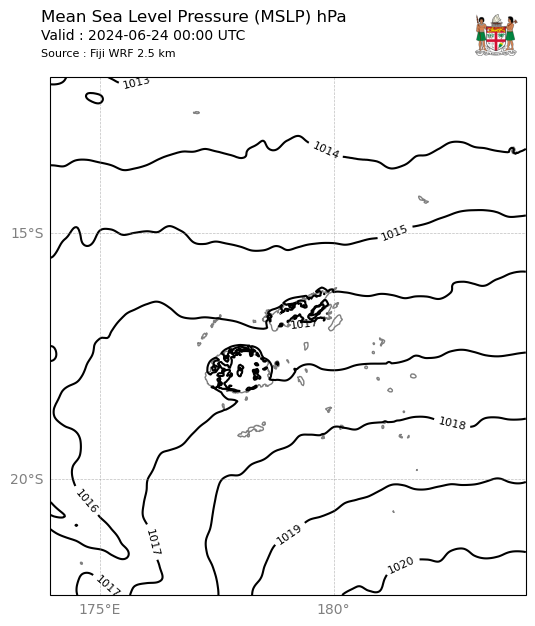

In [145]:
# Initiate figure and axes instance
fig, ax = plt.subplots(1, 1, figsize=(13, 7), subplot_kw={'projection': cart_proj})

levels = range(990,1028,2)
contour = ax.contour(to_np(lons), to_np(lats), to_np(slp), 8, colors="black",
            transform=crs.PlateCarree())

# get axes position
pos = ax.get_position() # get the original position

# Add contour labels
ax.clabel(contour, inline=True, fontsize=8)

# Set the map bounds
ax.set_xlim(cartopy_xlim(slp))
ax.set_ylim(cartopy_ylim(slp))

# Add coastlines and other features
ax.coastlines(color='gray')
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Draw gridlines with labels
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10, 'color': 'gray'}
gl.ylabel_style = {'size': 10, 'color': 'gray'}

# Set specific values for the gridlines
gl.xlocator = FixedLocator([165, 170, 175, 180, 185, 190, 195, 200, 205])
gl.ylocator = FixedLocator([-35, -30, -25, -20, -15, -10, -5])

# Set title and text info
main_title = 'Mean Sea Level Pressure (MSLP) hPa'
time_text = 'Valid : 2024-06-24 00:00 UTC'
model_text = 'Source : Fiji WRF 2.5 km'

ax.set_title(main_title, x=pos.x0, y=pos.y1 + 0.05, pad=25, fontsize=12,ha="left", transform=fig.transFigure)
ax.text(x=pos.x0, y=pos.y1 + 0.025, s=time_text,transform=fig.transFigure, size=10, ha="left")
ax.text(x=pos.x0, y=pos.y1 + 0.0, s = model_text, transform=fig.transFigure, size=8, ha="left")

# add logo
lgaxes = fig.add_axes([pos.x1 - 0.06, pos.y1 + 0.0, 0.06, 0.06], )  # l,b,w,h
lgaxes.imshow(plt.imread("D:/Projects/fiji-training-2024/data/Coat_of_arms_of_Fiji.png"))
lgaxes.axis("off")

plt.subplots_adjust(top=0.85)